In [1]:
from minlsh import MinHashLSHiForest
from data_loader import DataLoader
import numpy as np
from sklearn.metrics import roc_auc_score
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# unswの実験
print("Results of UNSW:")
X_train, y_train, X_test, y_test, y_cat = DataLoader.load_unsw_nb15_for_minhash(sample_frac=1)
print(f"X_train size is {len(X_train)}")
print(f"X_test size is {len(X_test)}")
X_train.head(5)
#X_test.head()

In [ ]:
# LSHiForestのインスタンス化と学習
lshif = MinHashLSHiForest(n_estimators=100, sample_size=256, eta=1.0)
start = time.time()
lshif.fit(X_train)
stop = time.time()
print(f"Trained Time: {stop -start}")

# 異常スコアの計算
start = time.time()
scores = lshif.decision_function(X_test)
stop = time.time()

# 2. AUCスコアを計算
print(f"Executed Time: {stop - start}")
auc_score = roc_auc_score(y_test, scores)
print(f"AUC Score: {auc_score}")

In [ ]:
# 攻撃別手法分析
results_df = pd.DataFrame({
    'attack_cat': y_cat,
    'label': y_test,
    'score': scores 
})

# 2. 正常データと攻撃データを分離
normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]

# 3. 各攻撃カテゴリのAUCスコアを計算
auc_scores_by_cat = {}
unique_attack_cats = sorted(attack_df['attack_cat'].unique())

for cat in unique_attack_cats:
    
    current_attack_df = attack_df[attack_df['attack_cat'] == cat]
    eval_df = pd.concat([normal_df, current_attack_df])
    auc = roc_auc_score(eval_df['label'], eval_df['score'])
    auc_scores_by_cat[cat] = auc

# --- 4. グラフの描画 -
plot_df = pd.DataFrame(list(auc_scores_by_cat.items()), columns=['Attack Category', 'AUC Score'])
plot_df = plot_df.sort_values('AUC Score', ascending=False)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(data=plot_df, x='Attack Category', y='AUC Score', color='darkcyan', ax=ax)
ax.set_title('MinHashLSHiForest Performance by Attack Category on UNSW-NB15', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='x', labelrotation=45, labelsize=12) 
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("AUC Scores (Each Attack Category vs. Normal Traffic):")
print(plot_df.to_string())

In [ ]:
# NSL
X_train, y_train, X_test, y_test = DataLoader.load_nsl_kdd_for_minhash(sample_frac=1)
y_true = np.array([0 if label == "normal" else 1 for label in y_test])
print(f"X_train size is {len(X_train)}")
print(f"X_test size is {len(X_test)}")

# LSHiForestのインスタンス化と学習
lshif = MinHashLSHiForest(n_estimators=100, sample_size=256, eta=1.0)
start = time.time()
lshif.fit(X_train)
stop = time.time()
print(f"Trained Time: {stop -start}")

# 異常スコアの計算
start = time.time()
scores = lshif.decision_function(X_test)
stop = time.time()

# 2. AUCスコアを計算
print(f"Executed Time: {stop-start}")
auc_scores = roc_auc_score(y_true, scores)
print(f"AUC Score: {auc_scores}")

In [ ]:
results_df = pd.DataFrame({
    'attack_cat': y_test,
    'label': [0 if label == 'normal' else 1 for label in y_test],
    'score': scores
})

# 2. 正常データと攻撃データを分離
normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]

# 3. 各攻撃カテゴリのAUCスコアを計算
auc_scores_by_cat = {}
# データセットに含まれる攻撃の種類（'normal'を除く）を取得
unique_attack_cats = sorted(attack_df['attack_cat'].unique())

for cat in unique_attack_cats:
    # 現在のカテゴリの攻撃データを抽出
    current_attack_df = attack_df[attack_df['attack_cat'] == cat]
    
    # 正常データと現在の攻撃データを結合して評価用データセットを作成
    eval_df = pd.concat([normal_df, current_attack_df])
    
    # AUCを計算
    # MinHashLSHiForestのスコアは「高いほど異常」なので、符号の反転は不要です。
    auc = roc_auc_score(eval_df['label'], eval_df['score'])
    auc_scores_by_cat[cat] = auc

# 結果をプロットしやすいようにDataFrameを整形
plot_df = pd.DataFrame(list(auc_scores_by_cat.items()), columns=['Attack Category', 'AUC Score'])
# スコアの高い順に並び替え
plot_df = plot_df.sort_values('AUC Score', ascending=False)


# グラフのスタイルとサイズを設定
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))

# seabornで棒グラフを描画 (分類器は1つなので色は固定)
sns.barplot(data=plot_df, x='Attack Category', y='AUC Score', color='steelblue', ax=ax)

# グラフのタイトルやラベルを設定
ax.set_title('LSHiForest Performance by Attack Category on NSL-KDD', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
# ラベルのフォントサイズや目盛りのスタイルを設定
ax.tick_params(axis='x', labelsize=12) 
plt.setp(ax.get_xticklabels(), rotation=60, ha='right')
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# レイアウトを自動調整し、グラフを表示
plt.tight_layout()
plt.show()

# --- 5. 数値結果の表示 ---
print("AUC Scores (Each Attack Category vs. Normal Traffic):")
print(plot_df)

In [ ]:
# unswでbinningした数値特徴量とカテゴリ値で実験
X_train, y_train, X_test, y_test, y_cat = DataLoader.load_unsw_nb15_with_binned_features(sample_frac=1)
print(f"X_train size is {len(X_train)}")
print(f"X_test size is {len(X_test)}")
X_train.head()

X_train size is 175341
X_test size is 82332


0    {sinpkt:0, sload:0, dloss:0, stcpb:1, proto:tc...
1    {sinpkt:0, sload:0, dloss:0, ct_srv_src:6, dtc...
2    {sinpkt:0, sload:0, dloss:0, proto:tcp, dur:0,...
3    {sinpkt:0, sload:0, dloss:0, service:ftp, prot...
4    {sinpkt:0, sload:0, dloss:0, ct_srv_src:6, pro...
dtype: object

In [3]:
# LSHiForestのインスタンス化と学習
lshif = MinHashLSHiForest(n_estimators=100, sample_size=256, eta=1.0)
start = time.time()
lshif.fit(X_train)
stop = time.time()
print(f"Trained Time: {stop -start}")

# 異常スコアの計算
start = time.time()
scores = lshif.decision_function(X_test)
stop = time.time()

# 2. AUCスコアを計算
print(f"Executed Time: {stop - start}")
auc_score = roc_auc_score(y_test, scores)
print(f"AUC Score: {auc_score}")

Trained Time: 1.9011130332946777
Executed Time: 270.9586901664734
AUC Score: 0.47462753415641


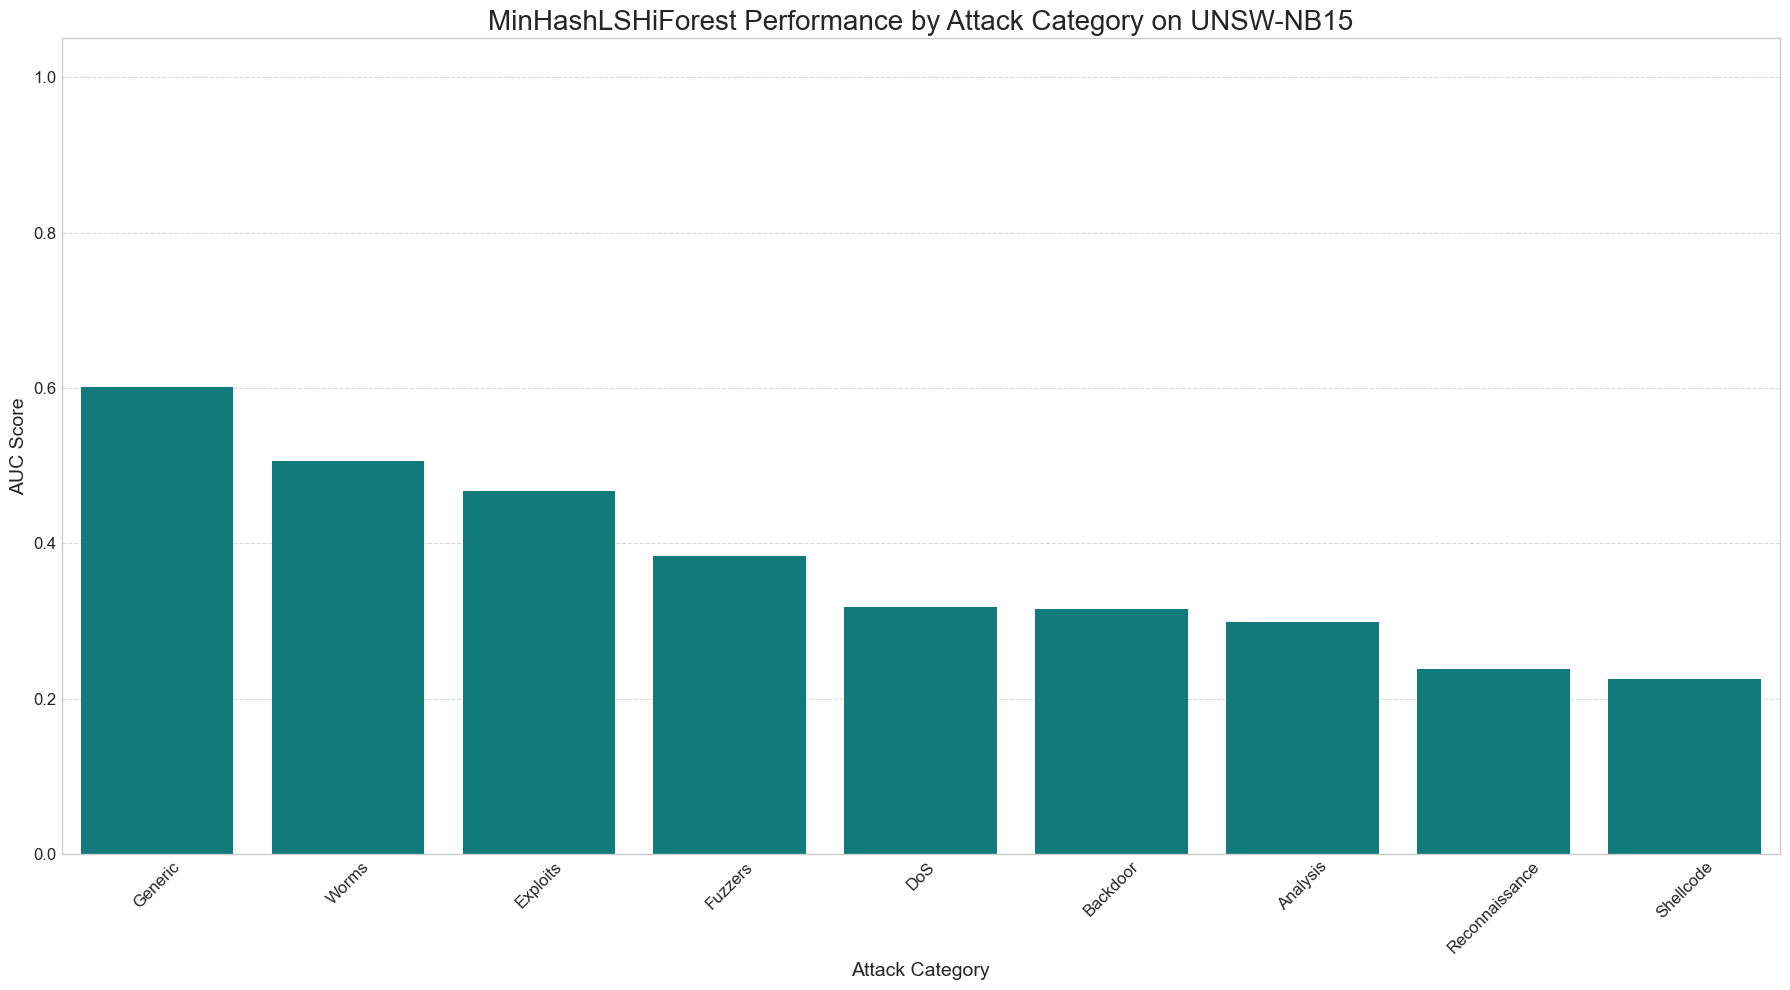

AUC Scores (Each Attack Category vs. Normal Traffic):
  Attack Category  AUC Score
5         Generic   0.601904
8           Worms   0.506040
3        Exploits   0.467559
4         Fuzzers   0.383827
2             DoS   0.317682
1        Backdoor   0.315467
0        Analysis   0.298977
6  Reconnaissance   0.238153
7       Shellcode   0.226150


In [4]:
# 攻撃別手法分析
results_df = pd.DataFrame({
    'attack_cat': y_cat,
    'label': y_test,
    'score': scores  # セル2で計算した異常度スコア
})

# 2. 正常データと攻撃データを分離
normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]

# 3. 各攻撃カテゴリのAUCスコアを計算
auc_scores_by_cat = {}
unique_attack_cats = sorted(attack_df['attack_cat'].unique())

for cat in unique_attack_cats:
    
    current_attack_df = attack_df[attack_df['attack_cat'] == cat]
    eval_df = pd.concat([normal_df, current_attack_df])
    auc = roc_auc_score(eval_df['label'], eval_df['score'])
    auc_scores_by_cat[cat] = auc

# --- 4. グラフの描画 -
plot_df = pd.DataFrame(list(auc_scores_by_cat.items()), columns=['Attack Category', 'AUC Score'])
plot_df = plot_df.sort_values('AUC Score', ascending=False)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(data=plot_df, x='Attack Category', y='AUC Score', color='darkcyan', ax=ax)
ax.set_title('MinHashLSHiForest Performance by Attack Category on UNSW-NB15', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='x', labelrotation=45, labelsize=12) # X軸ラベルを回転
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("AUC Scores (Each Attack Category vs. Normal Traffic):")
print(plot_df.to_string())

In [2]:
# NSL
X_train, y_train, X_test, y_test = DataLoader.load_nsl_kdd_with_binned_features(sample_frac=1)
y_true = np.array([0 if label == "normal" else 1 for label in y_test])
print(f"X_train size is {len(X_train)}")
print(f"X_test size is {len(X_test)}")

# LSHiForestのインスタンス化と学習
lshif = MinHashLSHiForest(n_estimators=100, sample_size=256, eta=1.0)
start = time.time()
lshif.fit(X_train)
stop = time.time()
print(f"Trained Time: {stop -start}")

# 異常スコアの計算
start = time.time()
scores = lshif.decision_function(X_test)
stop = time.time()

# 2. AUCスコアを計算
print(f"Executed Time: {stop-start}")
auc_scores = roc_auc_score(y_true, scores)
print(f"AUC Score: {auc_scores}")

X_train size is 125973
X_test size is 22544
Trained Time: 1.828167200088501
Executed Time: 88.93686103820801
AUC Score: 0.7733661951411935


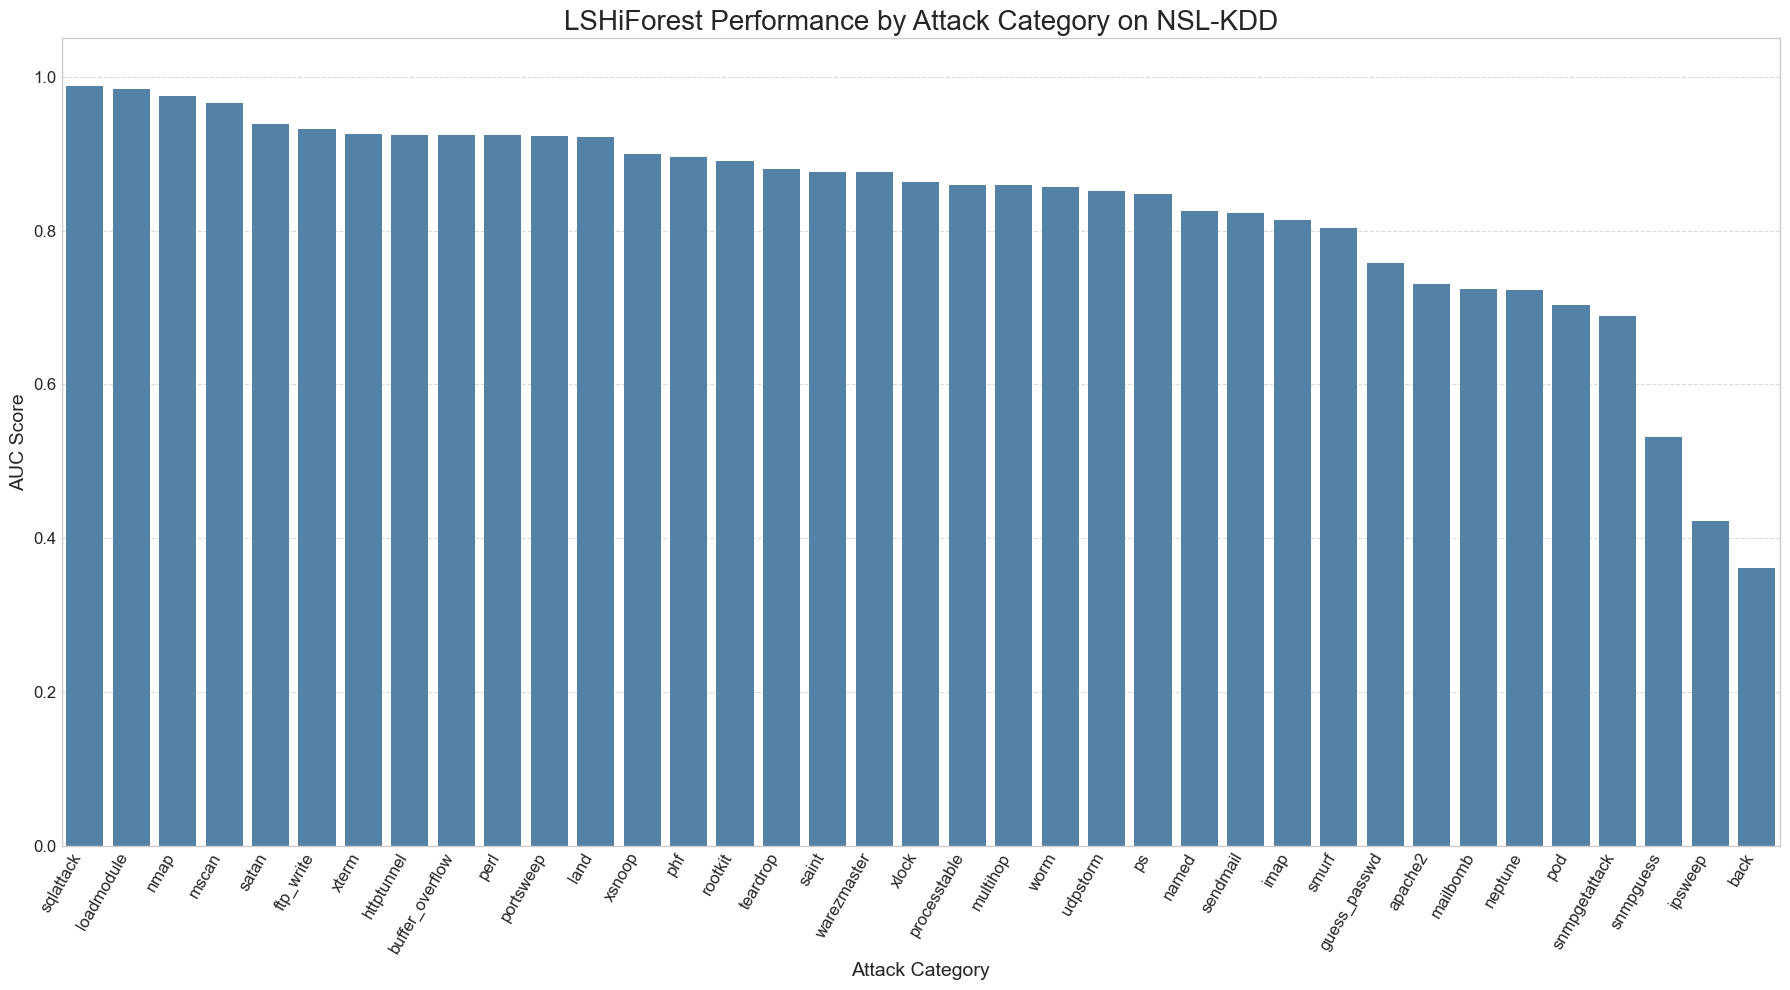

AUC Scores (Each Attack Category vs. Normal Traffic):
    Attack Category  AUC Score
29        sqlattack   0.988364
9        loadmodule   0.984142
15             nmap   0.975671
11            mscan   0.966167
24            satan   0.938410
3         ftp_write   0.932431
36            xterm   0.925632
5        httptunnel   0.924785
2   buffer_overflow   0.924578
16             perl   0.923901
19        portsweep   0.923134
8              land   0.922032
35           xsnoop   0.899817
17              phf   0.895325
22          rootkit   0.891040
30         teardrop   0.880775
23            saint   0.876830
32      warezmaster   0.875962
34            xlock   0.863797
20     processtable   0.859394
12         multihop   0.859278
33             worm   0.856863
31         udpstorm   0.851354
21               ps   0.847513
13            named   0.825880
25         sendmail   0.822506
6              imap   0.813613
26            smurf   0.802773
4      guess_passwd   0.757795
0           apac

In [3]:
results_df = pd.DataFrame({
    'attack_cat': y_test,
    'label': [0 if label == 'normal' else 1 for label in y_test],
    'score': scores
})

# 2. 正常データと攻撃データを分離
normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]

# 3. 各攻撃カテゴリのAUCスコアを計算
auc_scores_by_cat = {}
# データセットに含まれる攻撃の種類（'normal'を除く）を取得
unique_attack_cats = sorted(attack_df['attack_cat'].unique())

for cat in unique_attack_cats:
    # 現在のカテゴリの攻撃データを抽出
    current_attack_df = attack_df[attack_df['attack_cat'] == cat]
    
    # 正常データと現在の攻撃データを結合して評価用データセットを作成
    eval_df = pd.concat([normal_df, current_attack_df])
    
    # AUCを計算
    # MinHashLSHiForestのスコアは「高いほど異常」なので、符号の反転は不要です。
    auc = roc_auc_score(eval_df['label'], eval_df['score'])
    auc_scores_by_cat[cat] = auc

# 結果をプロットしやすいようにDataFrameを整形
plot_df = pd.DataFrame(list(auc_scores_by_cat.items()), columns=['Attack Category', 'AUC Score'])
# スコアの高い順に並び替え
plot_df = plot_df.sort_values('AUC Score', ascending=False)


# グラフのスタイルとサイズを設定
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))

# seabornで棒グラフを描画 (分類器は1つなので色は固定)
sns.barplot(data=plot_df, x='Attack Category', y='AUC Score', color='steelblue', ax=ax)

# グラフのタイトルやラベルを設定
ax.set_title('LSHiForest Performance by Attack Category on NSL-KDD', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
# ラベルのフォントサイズや目盛りのスタイルを設定
ax.tick_params(axis='x', labelsize=12) 
plt.setp(ax.get_xticklabels(), rotation=60, ha='right')
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# レイアウトを自動調整し、グラフを表示
plt.tight_layout()
plt.show()

# --- 5. 数値結果の表示 ---
print("AUC Scores (Each Attack Category vs. Normal Traffic):")
print(plot_df)